In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set()

# Model

Main equations

cp_outflow:

$$ min(maximum flow_{i}, previous V_{freeflow} )


In [26]:
# outflow
def cp_outflow(c):
    return np.min([c.cto[0].qmax, c.oldk * c.vf, c.cto[0].w * (c.cto[0].kjam - c.cto[0].oldk)]) * c.time_hour / c.length


def cp_outflow_will_merge(pfpc, c, rek, sbk, sck):
    return np.min([np.median([pfpc * rek, sbk, rek - sck]), c.vf * c.oldk * c.time_hour / c.length])


def cp_outflow_will_diverge(ptnc, sbk, rek, rck):
    return np.min([sbk, rek/(1-ptnc), rck/ptnc])


def cp_outflow_no_cto(c):
    return np.min([c.qmax, c.oldk * c.vf, c.dis_rate]) * c.time_hour / c.length


# inflow
def cp_inflow(c):
    return np.min([c.qmax, c.vf * c.cfrom[0].oldk, c.w * (c.kjam - c.oldk)]) * c.time_hour / c.length


def cp_inflow_merging(c, sbk, sck):
    return np.min([c.qmax * c.time_hour / c.length, sbk+sck, c.w * (c.kjam - c.oldk) * c.time_hour / c.length])


def cp_inflow_next_c(ptnc, sbk, rek, rck):
    return ptnc * np.min([sbk, rek/(1-ptnc), rck/ptnc])


def cp_inflow_diverge(ptnc, sbk, rek, rck):
    return (1-ptnc) * np.min([sbk, rek/(1-ptnc), rck/ptnc])


def cp_inflow_no_cfrom(c):
    return np.min([c.qmax, c.arr_rate, c.w * (c.kjam - c.oldk)]) * c.time_hour / c.length


# s & r
def cp_s(c):
    return np.min([c.qmax, c.vf * c.oldk]) * c.time_hour / c.length


def cp_r(c):
    return np.min([c.qmax, c.w * (c.kjam - c.oldk)]) * c.time_hour / c.length


# density
def cp_density(c):
    return c.oldk + np.max([0, c.inflow]) - np.max([0, c.outflow])

In [27]:
class Cell(object):
    idcase = {}                               
    def __init__(self, cellid, time_interval, k, qmax, kjam, vf, w, length, pk,
                 arr_rate=None, dis_rate=None, linkid='L', zoneid='Z'):
        self.kjam = kjam
        self.cellid = cellid # local address
        self.linkid = linkid # link layer address
        self.zoneid = zoneid # zone layer address
        self.vf = vf # free flow speed
        self.w = w # backwave speed
        self.cfrom = [] # connection from (upstream)
        self.cto = [] # connection to (downstream)
        self.k = k # density at time interval t
        self.oldk = k # density at time interval t-1
        self.qmax = qmax
        self.length = length
        self.arr_rate = arr_rate # arrival rate
        self.dis_rate = dis_rate # discharge rate
        self.time_sec = time_interval
        self.time_hour = time_interval / 3600
        self.inflow = 0
        self.outflow = 0
        self.pk = pk # density propotion going to next cell (0...1)
        
        self.updated = False
        
        if Cell.idcase.get(self.getCompleteAddress()) == None:
            Cell.idcase.setdefault(self.getCompleteAddress(), self)
        else:
            raise Exception("This id has been used by other cell")
        
    def addConnection(self, sink):
        if len(sink.cfrom) == 2 or len(self.cto) == 2:
            raise Exception("Cannot add more connection to cell %s and cell %s" % (self.getCompleteAddress(), sink.getCompleteAddress())) 
            
        if (len(self.cto) and len(sink.cfrom)) and (len(sink.cto) == 2 or len(self.cfrom) == 2):
            raise Exception("Invaild cell connection! A cell cannot connect to merge and diverge cell simultaneously")
            
        self.cto.append(sink) # An instance of cell class is stored, in order to use cto and cfrom as pointer.
        sink.cfrom.append(self)
        
    def deleteConnection(self, sink):
        if sink not in self.cto:
            raise Exception("Cell %s is not connected with cell %s" % (self.getCompleteAddress(), sink.getCompleteAddress()))
            
        self.cto.remove(sink)
        sink.cfrom.remove(self)
        
    def getCell(cid):
        return Cell.idcase[cid]
    
    def getFirstCell(linkid):
        newDict = {}
        for key in Cell.idcase:
            if Cell.idcase[key].linkid == linkid:
                newDict[key] = Cell.idcase[key]
                
        return newDict[min(newDict.keys())]
    
    def getLastCell(linkid):
        newDict = {}
        for key in Cell.idcase:
            if Cell.idcase[key].linkid == linkid:
                newDict[key] = Cell.idcase[key]
                
        return newDict[max(newDict.keys())]
    
    def deleteCell(cid):
        poped = Cell.idcase.pop(cid)
        for elem in poped.cto:
            poped.deleteConnection(elem)
        del poped
        
    def getCompleteAddress(self):
        return "%s.%s.%s" % (self.zoneid, self.linkid, self.cellid)
    
    def updateDensity(self): # This method can only be used by normal cell instance.
        
        if not self.updated:
            self.oldk = self.k
        
        if len(self.cfrom) == 2: # Merge at here, we need to update density among this cell and two other upstream cells.
            pfpc = self.pk         # Proportion From Previous (normal) Cell
            # pfmc = 1 - self.pk     # Proportion From Merging Cell
            for elem in self.cfrom:
                rek = cp_r(c=self)                                    # np.min([self.qmax, self.w * (self.kjam - self.oldk)]) * self.time_hour / self.length
                if elem.linkid == self.linkid:
                    sbk = cp_s(c=elem)                                     # np.min([elem.qmax, elem.vf * elem.oldk]) * elem.time_hour / elem.length
                    prov = elem
                    
                else:
                    sck = cp_s(c=elem)                                     # np.min([elem.qmax, elem.vf * elem.oldk]) * elem.time_hour / elem.length
                    if not elem.updated:
                        elem.oldk = elem.k
                        
                    merge = elem
            
            if len(prov.cfrom):    
                prov.inflow = cp_inflow(c=prov)                                        # np.min([prov.qmax, prov.vf * prov.cfrom[0].oldk, prov.w * (prov.kjam - prov.oldk)]) * prov.time_hour / prov.length
                prov.outflow = cp_outflow_will_merge(c=prov, pfpc=pfpc, rek=rek, sbk=sbk, sck=sck)    # np.min([np.median([pk * rek, sbk, rek - sck]), prov.vf * prov.oldk * prov.time_hour / prov.length])
            else:
                prov.inflow = cp_inflow_no_cfrom(c=prov)                               # np.min([prov.qmax, prov.arr_rate, prov.w * (prov.kjam - prov.oldk)]) * prov.time_hour / prov.length
                prov.outflow = cp_outflow_will_merge(c=prov, pfpc=pfpc, rek=rek, sbk=sbk, sck=sck)    # np.min([np.median([pk * rek, sbk, rek - sck]), prov.vf * prov.oldk * prov.time_hour / prov.length])
                    
            if len(merge.cfrom): # if there are connections from,                
                merge.inflow = cp_inflow(c=merge)                                      # np.min([merge.qmax, merge.vf * merge.cfrom[0].oldk, merge.w * (merge.kjam - merge.oldk)]) * merge.time_hour / merge.length
                merge.outflow = cp_outflow_will_merge(c=merge, pfpc=pfpc, rek=rek, sbk=sbk, sck=sck)  # merge.outflow = np.min([np.median([pck * rek, sck, rek - sbk]), merge.vf * merge.oldk * merge.time_hour / merge.length])
            else:
                merge.inflow = cp_inflow_no_cfrom(c=merge)                             # np.min([merge.qmax, merge.arr_rate, merge.w * (merge.kjam - merge.oldk)]) * merge.time_hour / merge.length
                merge.outflow = cp_outflow_will_merge(c=merge, pfpc=pfpc, rek=rek, sbk=sbk, sck=sck)  # np.min([np.median([pck * rek, sck, rek - sbk]), merge.vf * merge.oldk * merge.time_hour / merge.length])
                
            if len(self.cto):   # if there are connections to,                
                self.inflow = cp_inflow_merging(c=self, sbk=sbk, sck=sck)                  # np.min([self.qmax * self.time_hour / self.length, sbk+sck, self.w * (self.kjam - self.oldk) * self.time_hour / self.length])
                self.outflow = cp_outflow(c=self)                                  # np.min([self.cto[0].qmax, self.oldk * self.vf, self.cto[0].w * (self.cto[0].kjam - self.cto[0].oldk)]) * self.time_hour / self.length
            else:
                self.inflow = cp_inflow_merging(c=self, sbk=sbk, sck=sck)                  # np.min([self.qmax * self.time_hour / self.length, sbk+sck, self.w * (self.kjam - self.oldk) * self.time_hour / self.length])
                self.outflow = cp_outflow_no_cto(c)                                    # np.min([self.qmax, self.oldk * self.vf, self.dis_rate]) * self.time_hour / self.length
            
            prov.k = cp_density(c=prov)                                                # prov.oldk + np.max([0, prov.inflow]) - np.max([0, prov.outflow])
            merge.k = cp_density(c=merge)                                              # merge.oldk + np.max([0, merge.inflow]) - np.max([0, merge.outflow])
            self.k = cp_density(c=self)                                                # self.oldk + np.max([0, self.inflow]) - np.max([0, self.outflow])
            
            prov.updated, self.updated, merge.updated = True, True, True
            
        elif len(self.cto) == 2: # Diverge at here
            ptnc = self.pk       # Propotion Towards Next (normal) Cell
            # ptdc = 1 - self.pk   # Propotion Towards Diverging Cell
            for elem in self.cto:
                if elem.linkid == self.linkid:
                    elem.oldk = elem.k
                    next_c = elem
                
                else:
                    if not elem.updated:
                        elem.oldk = elem.k
                        
                    diverge = elem
            
            rck = cp_r(c=next_c)                                                                 # np.min([next_c.qmax, next_c.w * (next_c.kjam - next_c.oldk)]) * next_c.time_hour / next_c.length # Receive ability of next normal cell
            rek = cp_r(c=diverge)                                                                # np.min([diverge.qmax, diverge.w * (diverge.kjam - diverge.oldk)]) * diverge.time_hour / diverge.length
            sbk = cp_s(c=self)                                                                   # np.min([self.qmax, self.vf * self.oldk]) * self.time_hour / self.length
            
            if len(next_c.cto): 
                next_c.inflow = cp_inflow_next_c(ptnc=ptnc, sbk=sbk, rek=rek, rck=rck)  # ptnc * np.min([sbk, rek/ptdc, rck/ptnc])
                next_c.outflow = cp_outflow(c=next_c)                                              # np.min([next_c.cto[0].qmax, next_c.vf * next_c.oldk, next_c.cto[0].w * (next_c.cto[0].kjam - next_c.cto[0].oldk)]) * next_c.time_hour / next_c.length
            else:
                next_c.inflow = cp_inflow_next_c(ptnc=ptnc, sbk=sbk, rek=rek, rck=rck)   # ptnc * np.min([sbk, rek/ptdc, rck/ptnc])
                next_c.outflow = cp_outflow_no_cto(c=next_c)                                        # np.min([next_c.qmax, next_c.vf * next_c.oldk, next_c.dis_rate]) * next_c.time_hour / next_c.length
            
            if len(diverge.cto):
                diverge.inflow = cp_inflow_diverge(ptnc=ptnc, sbk=sbk, rek=rek, rck=rck)  # ptdc * np.min([sbk, rek/ptdc, rck/ptnc])
                diverge.outflow = cp_outflow(c=diverge)                                 # np.min([diverge.cto[0].qmax, diverge.oldk * diverge.vf, diverge.cto[0].w * (diverge.cto[0].kjam - diverge.cto[0].oldk)]) * diverge.time_hour / diverge.length
            else:
                diverge.inflow = cp_inflow_diverge(ptnc=ptnc, sbk=sbk, rek=rek, rck=rck)  # ptdc * np.min([sbk, rek/ptdc, rck/ptnc])
                diverge.outflow = cp_outflow_no_cto(c=diverge)                              # np.min([diverge.qmax, diverge.oldk * diverge.vf, diverge.dis_rate]) * diverge.time_hour / diverge.length
            
            if len(self.cfrom):
                self.inflow = cp_inflow(c=self)                                             # np.min([self.qmax, self.cfrom[0].oldk * self.vf, self.w * (self.kjam - self.oldk)]) * self.time_hour / self.length
                self.outflow = cp_outflow_will_diverge(ptnc=ptnc, sbk=sbk, rek=rek, rck=rck) # np.min([sbk, rek/ptdc, rck/ptnc])
            else:
                self.inflow =  cp_inflow_no_cfrom(c=self)        # np.min([self.qmax, self.arr_rate, self.w * (self.kjam - self.oldk)]) * self.time_hour / self.length
                self.outflow = cp_outflow_will_diverge(ptnc=ptnc, sbk=sbk, rek=rek, ptdc=ptdc, rck=rck) # np.min([sbk, rek/ptdc, rck/ptnc])
            
            next_c.k = cp_density(c=next_c)                     # next_c.oldk + np.max([0, next_c.inflow]) - np.max([0, next_c.outflow])
            diverge.k = cp_density(c=diverge)                   # diverge.oldk + np.max([0, diverge.inflow]) - np.max([0, diverge.outflow])
            self.k = cp_density(c=self)                         # self.oldk + np.max([0, self.inflow]) - np.max([0, self.outflow])
            next_c.updated, self.updated, diverge.updated = True, True, True
                    
        else: # Normal cell
            if self.updated:
                return
            
            if len(self.cfrom) == 0:
                self.inflow = cp_inflow_no_cfrom(c=self)        # np.min([self.qmax, self.arr_rate, self.w * (self.kjam - self.oldk)]) * self.time_hour / self.length
                self.outflow = cp_outflow(c=self)               # np.min([self.cto[0].qmax, self.oldk * self.vf, self.cto[0].w * (self.cto[0].kjam - self.cto[0].oldk)]) * self.time_hour / self.length
                
            elif len(self.cto) == 0:
                self.inflow = cp_inflow(c=self)                 # np.min([self.qmax, self.cfrom[0].oldk * self.vf, self.w * (self.kjam - self.oldk)]) * self.time_hour / self.length                
                self.outflow = cp_outflow_no_cto(c=self)        # np.min([self.qmax, self.oldk * self.vf, self.dis_rate]) * self.time_hour / self.length
            
            else:
                self.inflow = cp_inflow(c=self)                  # np.min([self.qmax, self.cfrom[0].oldk * self.vf, self.w * (self.kjam - self.oldk)]) * self.time_hour / self.length
                self.outflow = cp_outflow(c=self)                # np.min([self.cto[0].qmax, self.oldk * self.vf, self.cto[0].w * (self.cto[0].kjam - self.cto[0].oldk)]) * self.time_hour / self.length
 
            self.k = cp_density(c=self)                          # self.oldk + np.max([0, self.inflow]) - np.max([0, self.outflow])            
            self.updated = True

In [28]:
class node(object):
    idcase = {}
    def __init__(self, nid, x, y, ntype):
        self.id = nid
        self.x = x
        self.y = y
        self.type = ntype
        node.idcase[nid] = self
        
    def getNodeFromID(nid):
        return node.idcase[nid]
    
    def getNodeByType(nodetype):
        need_return = []
        for key in node.idcase:
            if node.idcase[key].type == nodetype:
                need_return.append(node.idcase[key])
                
        return need_return

In [29]:
class link(object):
    idcase = {}
    def __init__(self, lid, fnode, tnode, speed, num_of_lanes, length):
        self.id = str(lid)
        self.source = str(fnode)
        self.sink = str(tnode)
        self.length = length
        self.speed = speed
        self.num_of_lanes = num_of_lanes 
        link.idcase[str(lid)] = self
        
    def getLinkFromID(lid):
        return link.idcase[lid]

In [30]:
class trafficSignal(object):
    idcase = {}
    def __init__(self, tsid, corr_node):
        self.id = tsid
        self.node = corr_node
        self.phase = None
        self.turning = {}
        self.duration = 0
        trafficSignal.idcase[corr_node] = self
        
    def getPhaseByNode(corr_node):
        return trafficSignal.idcase[corr_node]

    def initPhase(self):
        corr_node = node.getNodeFromID(self.node)
        nodelist = []
        link_vector = {}
        if corr_node.type != 0:
            return 0

        for key in link.idcase:
            if link.idcase[key].sink != corr_node.id:
                continue

            nodelist.append(node.getNodeFromID(link.idcase[key].source))
            link_vector[key] = [node.getNodeFromID(link.idcase[key].source).x - corr_node.x, node.getNodeFromID(link.idcase[key].source).y - corr_node.y]

        for subkey in link_vector:
            if link_vector[subkey][1] >= link_vector[subkey][0]:
                if link_vector[subkey][1] >= -1 * link_vector[subkey][0]:
                    self.turning['southbound'] = link.getLinkFromID(subkey).source
                else:
                    self.turning['eastbound'] = link.getLinkFromID(subkey).source
            else:
                if link_vector[subkey][1] >= -1 * link_vector[subkey][0]:
                    self.turning['westbound'] = link.getLinkFromID(subkey).source
                else:
                    self.turning['northbound'] = link.getLinkFromID(subkey).source
                    
    def importPhase(self, filename):
        pass

    def setPhase(self, phase_num, max_phases, base_duration=60, left_turning_coef=1/3):
        sum_duration = 0
        self.phase = pd.DataFrame(columns=['id', 'phase', 'duration'])
        
        for i in range(max_phases):
            if (i + 1) % phase_num:
                duration = base_duration
            else:
                duration = base_duration * left_turning_coef

            if i < max_phases / phase_num and (i + 1) % phase_num:
                self.phase.loc[i] = [i, {self.turning.get("eastbound"):self.turning.get("westbound"), self.turning.get("westbound"):self.turning.get("eastbound")}, duration]
            elif i < max_phases / phase_num and not (i + 1) % phase_num:
                self.phase.loc[i] = [i, {self.turning.get("eastbound"):self.turning.get("southbound"), self.turning.get("westbound"):self.turning.get("northbound")}, duration]
            elif i >= max_phases / phase_num and (i + 1) % phase_num:
                self.phase.loc[i] = [i, {self.turning.get("southbound"):self.turning.get("northbound"), self.turning.get("northbound"):self.turning.get("southbound")}, duration]
            elif i >= max_phases / phase_num and not (i + 1) % phase_num:
                self.phase.loc[i] = [i, {self.turning.get("northbound"):self.turning.get("eastbound"), self.turning.get("southbound"):self.turning.get("westbound")}, duration]

            sum_duration += duration
            
        self.duration = sum_duration
        
    def getCurrentPhase(self, curr_time):
        curr_duration = curr_time % self.duration
        for i in range(len(self.phase)):
            curr_duration = curr_duration - self.phase.iloc[i]['duration']
            if curr_duration <= 0:
                return {'phase_timing':self.phase.iloc[i]['phase'], 'phase_number':self.phase.iloc[i]['id']}
    


In [31]:
def getCrossProduct(va, vb):
    return va[0]*vb[1] - va[1]*vb[0]


def getEuclideanDis(x1, x2, y1, y2):
    return np.sqrt(np.power(x2 - x1, 2) + np.power(y2 - y1, 2))


def timeDependentDemand(order, t, miu, gamma, t0, t2=0, t3=0):
    if order == 1:
        return gamma * t + t0 + miu
    elif order == 2:
        return gamma * (t - t0)*(t2 - t) + miu
    elif order == 3:
        tbar = t0 + (3*(t3 - t0)**2 - 4*(t2-t0)*(t3-t0)) / (4*(t3-t0) - 6*(t2-t0))
        return miu + gamma * (t - t0)*(t - t2)*(t - tbar)
    else:
        raise Exception("Invaild input parameter! Order of time dependtent demand formula must be 1, 2 or 3")

# Construct the network
## Cells 

In [32]:
Cell.idcase = {}

C1 = Cell(f'C1',
          time_interval=5, k=0, qmax=4500, kjam=120,
          vf=80, w=12, length=0.5, pk=0.999999,           # First cell
          arr_rate=0)                                     # arr_rate is for the first cell

C2 = Cell(f'C2',
          time_interval=5, k=0, qmax=4500, kjam=120,
          vf=80, w=12, length=0.15, pk=0.99999)

C3 = Cell(f'C3',
          time_interval=5, k=0, qmax=4500, kjam=120,
          vf=80, w=12, length=0.35, pk=0.94444)           # ramp out 

C4 = Cell(f'C4',
          time_interval=5, k=0, qmax=4500, kjam=120,
          vf=80, w=12, length=0.2, pk=0.94444)            # ramp out 

C5 = Cell(f'C5',
          time_interval=5, k=0, qmax=4500, kjam=120,
          vf=80, w=12, length=0.2, pk=0.99999)

C6 = Cell(f'C6',
          time_interval=5, k=0, qmax=4500, kjam=120,
          vf=80, w=12, length=0.05, pk=0.99999)           # Bus stop

C7 = Cell(f'C7',
          time_interval=5, k=0, qmax=4500, kjam=120,
          vf=80, w=12, length=0.05, pk=0.99999)

C8 = Cell(f'C8',
          time_interval=5, k=0, qmax=4500, kjam=120,
          vf=80, w=12, length=0.2, pk=0.96666)             # ramp out

C9 = Cell(f'C9',
          time_interval=5, k=0, qmax=4500, kjam=120,
          vf=80, w=12, length=0.1, pk=0.99999)             # ramp in 

C10 = Cell(f'C10',
          time_interval=5, k=0, qmax=4500, kjam=120,
          vf=80, w=12, length=0.1, pk=0.99999)            

C11 = Cell(f'C11',
          time_interval=5, k=0, qmax=4500, kjam=120,
          vf=80, w=12, length=0.1, pk=0.99999)            

C12 = Cell(f'C12',
          time_interval=5, k=0, qmax=4500, kjam=120,
          vf=80, w=12, length=0.1, pk=0.99999)            

C13 = Cell(f'C13',
          time_interval=5, k=0, qmax=4500, kjam=120,
          vf=80, w=12, length=0.3, pk=0.99999)            

C14 = Cell(f'C14',
          time_interval=5, k=0, qmax=4500, kjam=120,
          vf=80, w=12, length=0.3, pk=.97777)              # ramp out     

C15 = Cell(f'C15',
          time_interval=5, k=0, qmax=4500, kjam=120,
          vf=80, w=12, length=0.1, pk=0.99999)              

C16 = Cell(f'C16',
          time_interval=5, k=0, qmax=4500, kjam=120,
          vf=80, w=12, length=0.05, pk=0.99999)            # Bus stop 

C17 = Cell(f'C17',
          time_interval=5, k=0, qmax=4500, kjam=120,
          vf=80, w=12, length=0.05, pk=0.99999)

C18 = Cell(f'C18',
          time_interval=5, k=0, qmax=4500, kjam=120,
          vf=80, w=12, length=0.1, pk=0.99999)             # Ramp in 

C19 = Cell(f'C19',
          time_interval=5, k=0, qmax=4500, kjam=120,
          vf=80, w=12, length=0.2, pk=0.99999)             # Bus stop

C20 = Cell(f'C20',
          time_interval=5, k=0, qmax=4500, kjam=120,
          vf=80, w=12, length=0.03, pk=0.99999)             

C21 = Cell(f'C21',
          time_interval=5, k=0, qmax=4500, kjam=120,
          vf=80, w=12, length=0.27, pk=0.99999)             

C22 = Cell(f'C22',
          time_interval=5, k=0, qmax=4500, kjam=120,
          vf=80, w=12, length=0.1, pk=0.99999)             

C23 = Cell(f'C23',
          time_interval=5, k=0, qmax=4500, kjam=120,
          vf=80, w=12, length=0.4, pk=0.99999,
          dis_rate=8038)                                   # The last cell

cells = [C1, C2, C3, C4, C5,C6, C7, C8, C9, C10, C11, C12,
         C13, C14, C15, C16, C17, C18, C19, C20, C21, C22, C23]

## Ramps

In [33]:
# in(on)- and off-ramp

for index in range(len(cells)):
    if index < len(cells) - 1:
        cells[index].addConnection(cells[index + 1])

D1 = Cell('D1', 
          time_interval=5, k=0, qmax=700, kjam=200, 
          vf=45, w=12, length=0.35, pk=0.99999,
          arr_rate=0,
          dis_rate=639,
          linkid='', zoneid='')
cells[2].addConnection(D1)

D2 = Cell('D2', 
          time_interval=5, k=0, qmax=700, kjam=200, 
          vf=45, w=12, length=0.28, pk=0.99999,
          arr_rate=0,
          dis_rate=639,
          linkid='', zoneid='') 
cells[3].addConnection(D2)
                
M1 = Cell('M1',
          time_interval=5, k=0, qmax=700, kjam=200, 
          vf=45, w=12, length=0.14, pk=0.99999,
          arr_rate=0,
          dis_rate=0,
          linkid='', zoneid='')  
M1.addConnection(cells[4])

D3 = Cell('D3', 
          time_interval=5, k=0, qmax=700, kjam=200, 
          vf=45, w=12, length=0.18, pk=0.99999,
          arr_rate=0,
          dis_rate=274,
          linkid='', zoneid='') 
cells[7].addConnection(D3)

M2 = Cell('M2',
          time_interval=5, k=0, qmax=700, kjam=200,
          vf=45, w=12, length=0.26, pk=0.99999,
          arr_rate=0,
          dis_rate=0, 
          linkid='', zoneid='')  
M2.addConnection(cells[9])

D4 = Cell('D4',
          time_interval=5, k=0, qmax=700, kjam=200,
          vf=45, w=12, length=0.23, pk=0.99999,
          arr_rate=0,
          dis_rate=274,
          linkid='', zoneid='')
cells[13].addConnection(D4)

M3 = Cell('M3',
          time_interval=5, k=0, qmax=700, kjam=200,
          vf=45, w=12, length=0.21, pk=0.99999,
          arr_rate=0,
          dis_rate=0,
          linkid='', zoneid='')  
M3.addConnection(cells[17])


cells.extend([D1, D2, M1, D3, M2, D4, M3])

## Links

In [10]:
# link.idcase = {}
# links = []

# L1 = Link(f'L1', self.id = str(lid),
#           self.source = str(fnode), 
#           self.sink = str(tnode),
#           self.length = length,
#           self.speed = speed,
#           self.num_of_lanes = num_of_lanes,
#           link.idcase[str(lid)] = self)
# links.append(L1)


# self, lid, fnode, tnode, speed, num_of_lanes, length

## Nodes

In [11]:
# node.idcase = {}
# nodes = []

# N1 = Node(f'N1',
#           self.id = nid,
#           self.x = x,
#           self.y = y,
#           self.type = ntype,
#           node.idcase[nid] = self)
# nodes.append(N1)


# Here simulation begins

In [12]:
# Number of timesteps
endtime = 36

flow_agr5 = [198, 190, 227, 265, 348, 360, 353, 389, 361, 346, 199, 149, 
              121, 131, 120, 219, 375, 337, 337, 344, 362, 288, 274, 282, 
              152, 248, 319, 333, 246, 263, 293, 283, 286, 282, 306, 277]

# speed_agr5 = [90.808081, 88.273684, 88.753304, 87.592453, 83.767241, 85.777778, 83.144476, 83.856041, 84.346260, 78.722543, 36.361809, 29.597315,
#                42.561983, 36.900763, 28.791667, 34.502283, 58.744000, 73.611276, 70.919881, 46.436047, 49.370166, 32.267361, 29.237226, 29.180851,
#                20.210526, 25.568548, 52.849530, 56.186186, 35.447154, 34.882129, 31.037543, 31.886926, 37.017483, 33.815603, 46.924837, 74.126354]

# density_agr5 = [2.180423, 2.152397, 2.557651, 3.025375, 4.154369, 4.196891, 4.245622, 4.638903, 4.279976, 4.395183, 5.472775, 5.034240, 
#                 2.842913, 3.550062, 4.167873, 6.347406, 6.383631, 4.578103, 4.751841, 7.408038, 7.332363, 8.925428, 9.371614, 9.663872,
#                 7.520833, 9.699416, 6.036005, 5.926724, 6.939908, 7.539677, 9.440180, 8.875111, 7.726079, 8.339346, 6.521067, 3.736863]


# Create a dataframe for storing the results
dfindex = []
for elem in cells:
    dfindex.append(elem.getCompleteAddress())
df = pd.DataFrame(index=dfindex)

# Run the simulation
for t in range(endtime):
    density = []
    
    cells[0].arr_rate = flow_agr5[t]
    #cells[0].vf = speed_agr5[t]
    #cells[0].k = density_agr5[t]
        
    for elem in cells:
        elem.updateDensity()
    for elem in cells:
        density.append(elem.k)
        elem.updated = False
    df[t] = density

In [13]:
df

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
Z.L.C1,0.55,0.955556,1.373765,1.804595,2.370241,2.843521e+00,3.192183e+00,3.563364,3.774283,3.896665,...,3.398836,3.568539,3.458864,3.420783,3.474498,3.488498,3.507721,3.511561,3.581214,3.554833
Z.L.C2,0.00,0.407407,0.813443,1.228497,1.655236,2.184869e+00,2.672759e+00,3.057517,3.432219,3.685600,...,3.267589,3.364809,3.515720,3.473605,3.434478,3.464122,3.482179,3.501099,3.508848,3.562452
Z.L.C3,0.00,0.000000,0.129336,0.346513,0.626508,9.530882e-01,1.344130e+00,1.765917,2.175949,2.574765,...,3.526638,3.444400,3.419133,3.449796,3.457354,3.450092,3.454546,3.463318,3.475312,3.485959
Z.L.C4,0.00,0.000000,0.000000,0.071853,0.224442,4.478117e-01,7.285208e-01,1.070526,1.456854,1.856351,...,3.545447,3.534998,3.484666,3.448259,3.449113,3.453691,3.451692,3.453277,3.458856,3.467998
Z.L.C5,0.00,0.000000,0.000000,0.000000,0.039918,1.424314e-01,3.120871e-01,0.543439,0.836265,1.181037,...,3.383155,3.473317,3.507584,3.494852,3.468967,3.457937,3.455578,3.453419,3.453340,3.456404
Z.L.C6,0.00,0.000000,0.000000,0.000000,0.000000,8.870760e-02,2.080938e-01,0.439190,0.670855,1.038433,...,2.719459,4.194339,2.592068,4.626548,2.111668,5.127888,1.416885,5.947314,0.405325,7.178692
Z.L.C7,0.00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.971280e-01,0.221496,0.705260,0.628804,...,7.232588,-2.796588,6.524165,-2.213827,8.067390,-5.167549,6.227758,-4.463071,8.753183,-9.797613
Z.L.C8,0.00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.109516,0.171727,0.468134,...,1.750001,4.795882,2.131503,4.571871,2.031943,5.384969,2.393320,4.523563,2.010473,5.756423
Z.L.C9,0.00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.121684,0.177287,...,4.203651,1.477373,5.164606,1.794492,4.880468,1.715440,5.792694,2.015611,4.802225,1.700278
Z.L.C10,0.00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.135204,...,1.183707,4.539200,1.137170,5.612099,1.370313,5.270486,1.320435,6.289612,1.540722,5.164614


# Plot

In [14]:
df_flip = df.T
df_flip

,Z.L.C1,Z.L.C2,Z.L.C3,Z.L.C4,Z.L.C5,Z.L.C6,Z.L.C7,Z.L.C8,Z.L.C9,Z.L.C10,...,Z.L.C21,Z.L.C22,Z.L.C23,..D1,..D2,..M1,..D3,..M2,..D4,..M3
0,0.550000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.000000,0.0,0.000000,0.0
1,0.955556,0.407407,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.000000,0.0,0.000000,0.0
2,1.373765,0.813443,0.129336,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.000000,0.0,0.000000,0.0
3,1.804595,1.228497,0.346513,0.071853,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.000000,0.0,0.000000,0.0
4,2.370241,1.655236,0.626508,0.224442,0.039918,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.000000,0.0,0.000000,0.0
5,2.843521,2.184869,0.953088,0.447812,0.142431,0.088708,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.217690e-07,0.000000,0.0,0.000000,0.0,0.000000,0.0
6,3.192183,2.672759,1.344130,0.728521,0.312087,0.208094,0.197128,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,9.734529e-07,0.000002,0.0,0.000000,0.0,0.000000,0.0
7,3.563364,3.057517,1.765917,1.070526,0.543439,0.439190,0.221496,0.109516,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.533439e-06,0.000006,0.0,0.000000,0.0,0.000000,0.0
8,3.774283,3.432219,2.175949,1.456854,0.836265,0.670855,0.705260,0.171727,0.121684,0.000000,...,0.000000,0.000000,0.000000,5.100146e-06,0.000015,0.0,0.000000,0.0,0.000000,0.0
9,3.896665,3.685600,2.574765,1.856351,1.181037,1.038433,0.628804,0.468134,0.177287,0.135204,...,0.000000,0.000000,0.000000,8.835323e-06,0.000026,0.0,0.000000,0.0,0.000000,0.0


Text(0, 0.5, 'density')

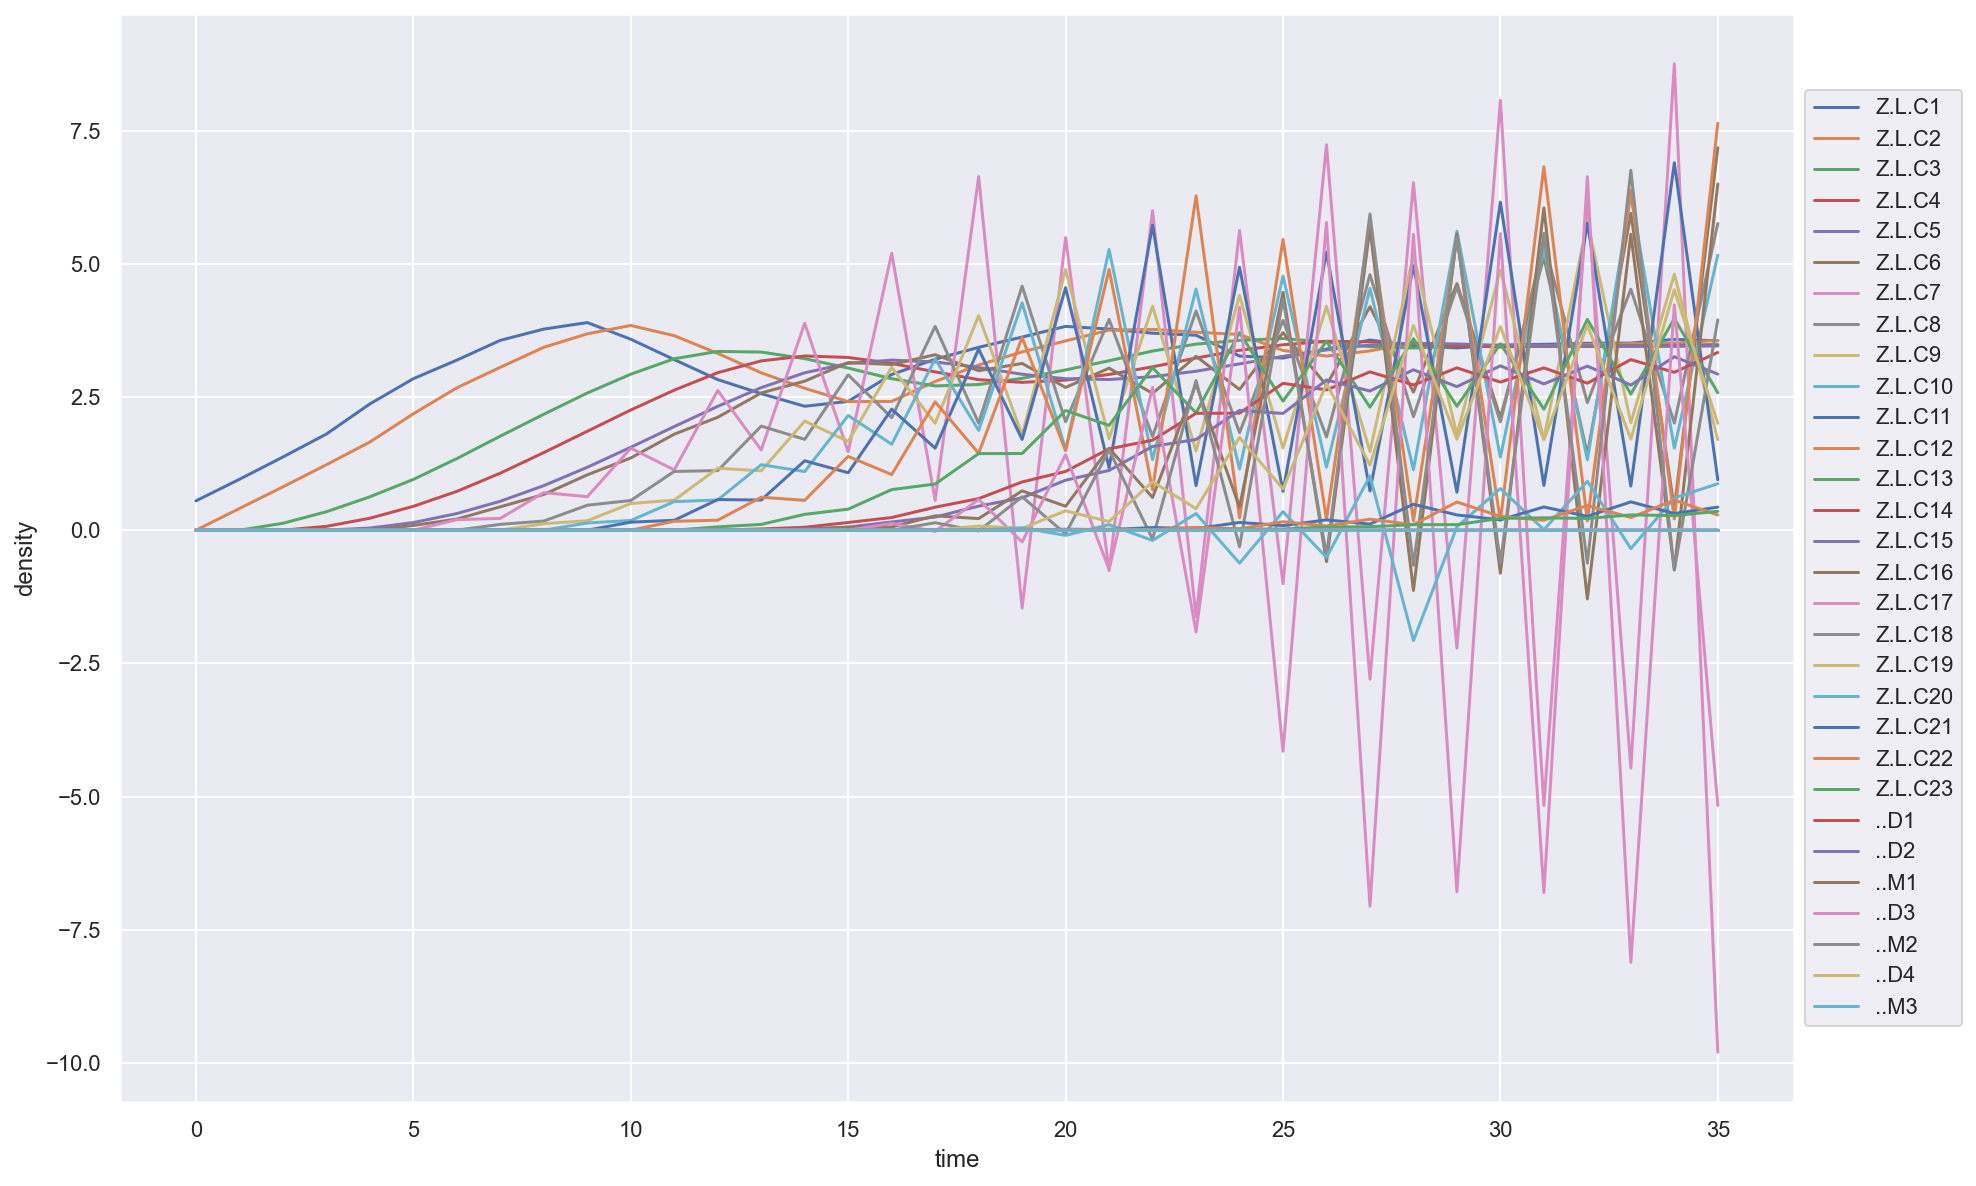

In [24]:
fig,ax = plt.subplots(figsize=(15, 10))

for name in df_flip.columns:
    ax.plot(df_flip[name], label=name)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('time')
ax.set_ylabel('density')